**In this notebook we will preprocess the data for the cardiac detection task. We provide bounding boxes for around 500 images of the RSNA pneumonia detection challenge dataset which you have already downloaded in the last section.**

**We will again convert the images to npy files for efficient storage and faster data loading.**

# Imports
* pathlib for easy path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualization
* patches from matplotlib to draw bounding boxes

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

At first, we read the csv file containing the labels

In [2]:
labels = pd.read_csv("/kaggle/input/heart-detection-data/rsna_heart_detection.csv")

In [3]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_PATH = Path("/kaggle/input/heart-detection/stage_2_train_images", )
SAVE_PATH = Path("Processed-Heart-Detection/")

Let's visualize some images with corresponding bounding boxes around the heart

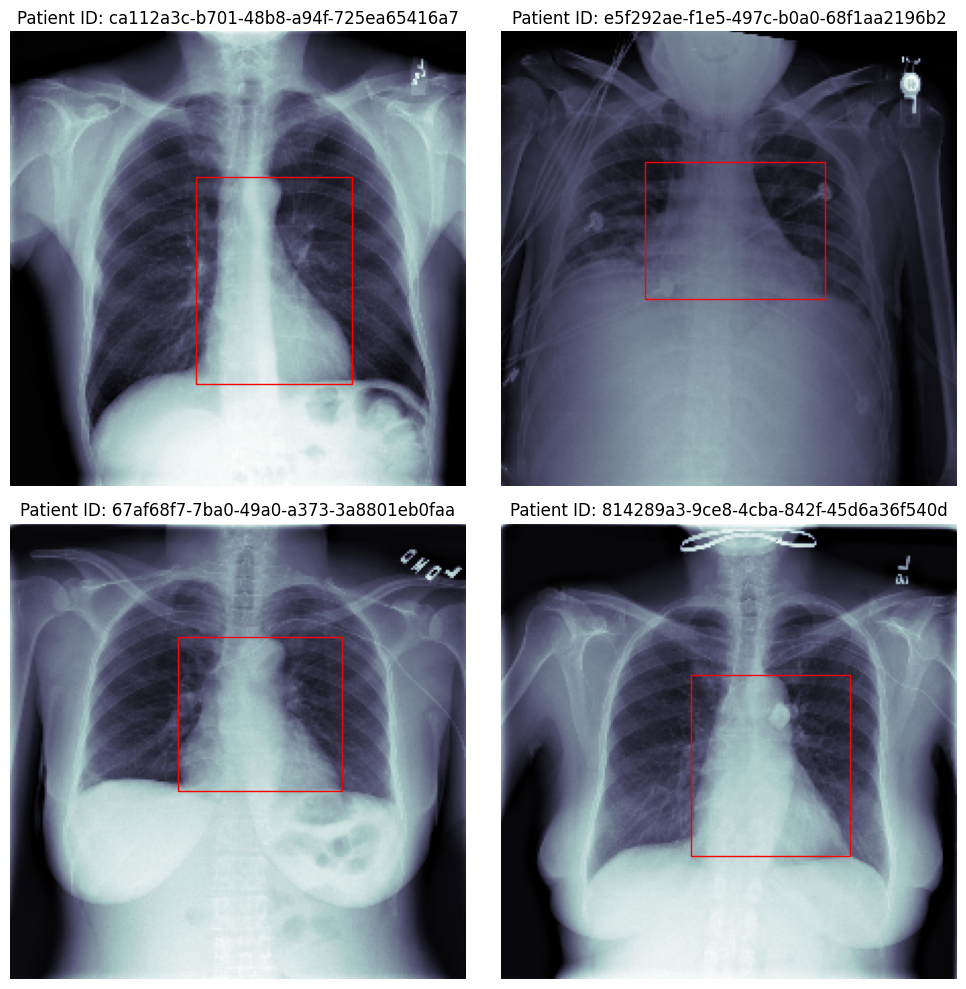

In [6]:
# Assuming labels is a DataFrame with the required columns
# Assuming ROOT_PATH is defined as a Path object

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Set figure size
c = 0

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

for ax in axes_flat:
    if c < len(labels):  # Check if we have enough labels
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH / str(patient_id)
        dcm_path = dcm_path.with_suffix(".dcm")

        # Read the DICOM file using dcmread
        dcm = pydicom.dcmread(dcm_path)  # Use dcmread() instead of read_file
        dcm_array = dcm.pixel_array

        # Resize the DICOM image
        dcm_array = cv2.resize(dcm_array, (224, 224))

        # Get bounding box coordinates
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        # Display the DICOM image
        ax.imshow(dcm_array, cmap="bone")
        
        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="r", facecolor='none')
        ax.add_patch(rect)

        # Set title or other attributes if needed
        ax.set_title(f"Patient ID: {patient_id}")
        ax.axis('off')  # Hide axes ticks

        c += 1
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the figure

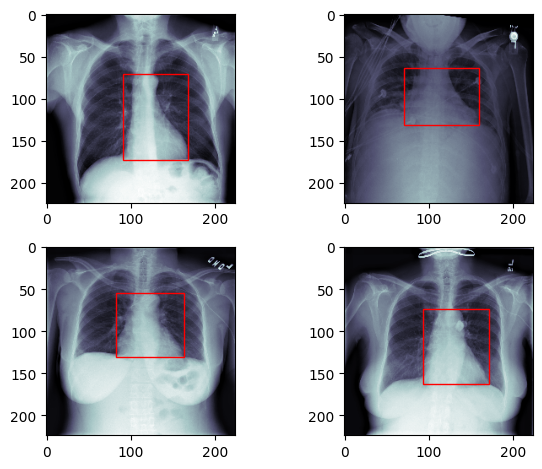

In [7]:
fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]  # Get the c-th row of the labels
        
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
        dcm = pydicom.dcmread(dcm_path)  # Read the dicom file with pydicom
        
        # Retrieve the actual image and resize it to match the labels
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))
        
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(rect)

        c+=1
plt.tight_layout()

We use a similar preprocessing routine to the one used for the classification task.
To be able to distinguish between train and validation subjects, we store them in two lists and later save these lists.

In [8]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):  
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    dcm = pydicom.dcmread(dcm_path)  # Read the dicom file with pydicom
    
     # Retrieve the actual image 
    dcm_array = dcm.pixel_array
    assert dcm_array.shape == (1024, 1024)
    
    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)
            
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val" 
    
    # Add to corresponding train or validation patient index list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
    
    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

In [9]:
sums

197.72066326530597

Finally we store the train and val subject ids

In [10]:
np.save("Processed-Heart-Detection/train_subjects_det", train_ids)
np.save("Processed-Heart-Detection/val_subjects_det", val_ids)

In [11]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)

We will use mean and std later in the dataloader to normalize our data

In [12]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49430165816326493, STD: 0.2527964897943661


**In this we will create a custom DataSet which will load and return an X-Ray image together with the location of the heart**

# Imports
* Path for easy path handling
* torch for dataset creation
* numpy for loading the images
* pandas for loading the csv file containing the labels
* imgaug to set a random seed for augmentations
* BoundingBox from imgaug to automatically handle the coordinates when augmenting the image

In [13]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

# DataSet Creation
Now we define the torch dataset! We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

Important: Augment bounding box together with image!
You can use BoundingBox(x1, y1, x2, y2) for that.
Next you call self.augment(image=img, bounding_boxes=bb) which returns the augmented image and bounding boxes
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.

bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

In [14]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


# Validate functionality

In [15]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [16]:
# First create the augmentation object

seq = iaa.Sequential([
            iaa.GammaContrast(),
            iaa.Affine(
                scale=(0.8, 1.2),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])


In [18]:
labels_path = "/kaggle/input/heart-detection-data/rsna_heart_detection.csv"
patients_path = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/train_subjects_det.npy"
train_root = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

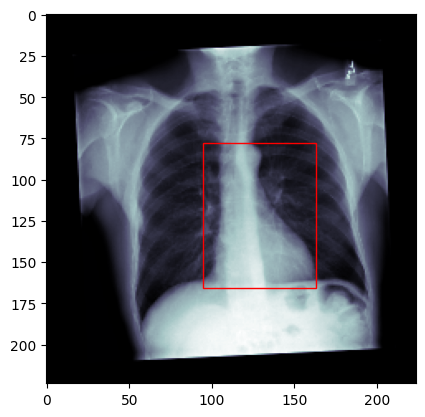

In [19]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

tensor([ 68.6318,  56.6990, 153.0819, 154.7767])


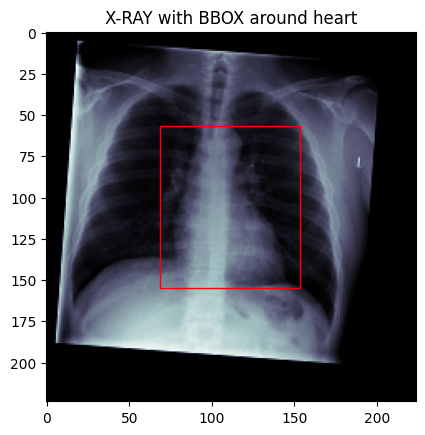

In [20]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

Awesome! Now we can move to training the heart detection network

**We are ready to train the Cardiac Detection Model now!**

# Imports
* torch and torchvision for model and dataloader creation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* numpy data loading
* cv2 for drawing rectangles on images
* imgaug for augmentation pipeline
* Our CardiacDataset

In [22]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
#from dataset import CardiacDataset


We create the dataset objects and the augmentation parameters to specify the augmentation parameters

In [23]:
train_root_path = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/train"
train_subjects = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/train_subjects_det.npy"
val_root_path = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/val"
val_subjects = "/kaggle/input/processed-heart-detection/Processed-Heart-Detection/val_subjects_det.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [24]:
train_dataset = CardiacDataset("/kaggle/input/heart-detection-data/rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("/kaggle/input/heart-detection-data/rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [25]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [26]:
train_dataset = CardiacDataset(
    "/kaggle/input/heart-detection-data/rsna_heart_detection.csv",
     train_subjects,
     train_root_path,
     augs = train_transforms)

val_dataset = CardiacDataset(
    "/kaggle/input/heart-detection-data/rsna_heart_detection.csv",
     val_subjects,
     val_root_path,
     augs=None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


Adapt batch size and num_workers according to your computing hardware.

In [27]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Model Creation
We use the same architecture as we used in the classifcation task with some small adaptations:

* 4 outputs: Instead of predicting a binary label we need to estimate the location of the heart (xmin, ymin, xmax, ymax).
* Loss function: Instead of using a cross entropy loss, we are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values.

In [28]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512 ,out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [29]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [30]:
model = CardiacDetectionModel() 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 


In [31]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

Train for at least 50 epochs to get a decent result. 100 epochs lead to great results.

In [33]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

# Create the trainer
# Specify the number of available GPUs or use 0 for CPU training

devices = 1  # Change this to the number of available GPUs
trainer = pl.Trainer(
    devices=devices, 
    accelerator='gpu',
    logger=TensorBoardLogger("./logs"), 
    log_every_n_steps=1,
    default_root_dir="./weights", 
    callbacks=checkpoint_callback,
    max_epochs=100
)


In [34]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Evaluation

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [38]:
# Assuming your model class is named CardiacDetectionModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model using the class method
model = CardiacDetectionModel.load_from_checkpoint("/kaggle/input/weights-heart/weight.ckpt")

# Set the model to evaluation mode and move it to the appropriate device
model.eval()
model.to(device)


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Compute prediction for all validation samples

In [39]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

Compute mean deviation between prediction and labels for each coordinate

In [40]:
abs(preds-labels).mean(0)

tensor([8.3507, 5.5605, 5.9872, 5.7408])

**Example prediction:**

tensor([ 85,  52, 174, 126])


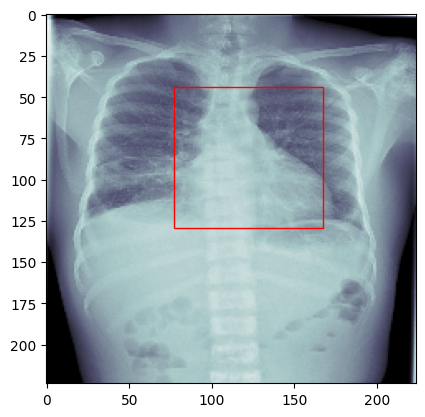

In [41]:
IDX = 60  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

**Awesome, looks like we got a working heart detection!**